# Web Scraping NLP


In [ ]:
# Set up for running selenium in Google Colab
%%shell
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb
CHROME_DRIVER_VERSION=`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`
wget -N https://chromedriver.storage.googleapis.com/$CHROME_DRIVER_VERSION/chromedriver_linux64.zip -P /tmp/
unzip -o /tmp/chromedriver_linux64.zip -d /tmp/
chmod +x /tmp/chromedriver
mv /tmp/chromedriver /usr/local/bin/chromedriver

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
25 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
w

In [ ]:
!pip install praw
!pip install yfinance
!pip install selenium

In [ ]:
import requests
import pandas as pd
import pytz
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go
import seaborn as sns
import praw
import re
import nltk
import sys
import time
import warnings
import tensorflow.compat.v1 as tf
import chromedriver_autoinstaller


from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from datetime import timedelta
from datetime import datetime, timedelta
from dateutil import parser
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk.util import ngrams
from nltk.stem import PorterStemmer
from pprint import pprint
from collections import Counter
from bs4 import BeautifulSoup

if not sys.warnoptions:
    warnings.simplefilter('ignore')

# Set up for running selenium in Google Colab

In [ ]:
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

# setup chrome options
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# set path to chromedriver as per your configuration
chromedriver_autoinstaller.install()

'/usr/local/lib/python3.10/dist-packages/chromedriver_autoinstaller/120/chromedriver'

# Reddit Data

### Usage
1. Specify subreddit name and search query.
2. Retrieve and process relevant data from Reddit submissions using the `search` method.
3. Apply the `is_interesting` filter to select interesting posts.
4. Extract post data using the `get_post_data` function.
5. Create a DataFrame (`df`) containing the collected data.

In [ ]:
def is_interesting(title):
    # Check if the title contains any keywords indicating interesting content
    keywords = [
        'surge', 'soars', 'plummets', 'spikes', 'rallies', 'crashes', 'jumps', 'drops', 'surges', 'falls',
        'halving', 'regulation', 'adoption', 'partnership', 'breakthrough', 'development', 'upgrade', 'launch', 'announcement',
        'news', 'report', 'analysis', 'update', 'announcement', 'insight', 'forecast', 'review', 'trend',
        'bullish', 'bearish', 'optimism', 'pessimism', 'positive', 'negative', 'sentiment', 'outlook',
        'cryptocurrency', 'blockchain', 'BTC', 'Bitcoin', 'digital currency', 'decentralized', 'crypto', 'blockchain technology',
        'price', 'investment', 'trading', 'wallet', 'mining', 'technology', 'finance', 'market', 'exchange', 'payment'
    ]

    return any(keyword in title.lower() for keyword in keywords)

def get_local_datetime(timestamp_utc, timezone):
    # Convert UTC timestamp to local datetime string
    datetime_utc = datetime.utcfromtimestamp(timestamp_utc).replace(tzinfo=pytz.utc)
    datetime_local = datetime_utc.astimezone(pytz.timezone(timezone))
    return datetime_local.strftime('%Y-%m-%d %H:%M:%S')

def get_comment_data(comments, timezone):
    # Extract relevant data from comments
    comment_data = []
    for comment in comments.list():
        if isinstance(comment, praw.models.MoreComments):
            # Ignore MoreComments objects
            continue

        reply_data = get_comment_data(comment.replies, timezone)
        comment_info = {
            'text': comment.body,
            'comment_date': get_local_datetime(comment.created_utc, timezone),
            'replies': reply_data,
        }
        comment_data.append(comment_info)

    return comment_data

def get_post_data(submission, timezone):
    # Extract relevant data from a Reddit submission
    return {
        'title': submission.title,
        'url': submission.url,
        'num_comments': submission.num_comments,
        'comments': get_comment_data(submission.comments, timezone),
        'publish_date': get_local_datetime(submission.created_utc, timezone),
        'score': submission.score,
    }

def main():
    # Set up Reddit API authentication
    reddit = praw.Reddit(client_id=REDDIT_CLIENT_ID,
                         client_secret=REDDIT_CLIENT_SECRET,
                         user_agent=REDDIT_USER_AGENT)

    subreddit_name = 'all'
    search_query = 'Bitcoin'

    data_list = []
    local_timezone = 'America/New_York'

    # Retrieve and process relevant data from Reddit submissions
    for submission in reddit.subreddit(subreddit_name).search(search_query, sort='top', time_filter='month', limit=1000):
        if is_interesting(submission.title):
            post_data = get_post_data(submission, local_timezone)
            data_list.append(post_data)

    df = pd.DataFrame(data_list)

    return df

# Sentiment Analysis with VADER

### Usage
1. Define a title and comment text.
2. Utilize the `analyze_sentiment_vader` function to perform sentiment analysis using the VADER library.
3. The function returns a dictionary with the processed text, sentiment label, sentiment scores, and label.
4. Optionally, apply sentiment analysis recursively to a list of comments using the `analyze_sentiment_recursive_vader` function.
5. Store the results in lists (`all_titles`, `all_texts`, etc.) for further analysis or visualization.



In [ ]:
def preprocess_text(text):
    # Preprocess text by removing special characters, URLs, and stopwords
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'[^A-Za-z$₿ ]+', '', text)

    # Tokenize the text
    words = nltk.word_tokenize(text)

    # Convert words to lowercase and remove stopwords
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

    # Join the processed words back into a string
    processed_text = ' '.join(words)

    return processed_text

def analyze_sentiment_vader(title, comment_text):
    # Analyze sentiment using VADER
    sentiment_scores = sia.polarity_scores(comment_text)

    # Classify sentiment as 'positive', 'negative', or 'neutral'
    if sentiment_scores['compound'] >= 0.1:
        sentiment_label = 'positive'
        label = 1
    elif sentiment_scores['compound'] <= -0.1:
        sentiment_label = 'negative'
        label = -1
    else:
        sentiment_label = 'neutral'
        label = 0

    return {
        'title': title,
        'text': comment_text,
        'processed_text': preprocess_text(comment_text),
        'sentiment_label': sentiment_label,
        'sentiment_scores': sentiment_scores,
        'label': label
    }

def analyze_sentiment_recursive_vader(title, comments_list):
    # Apply sentiment analysis recursively to each comment in the list
    for comment in comments_list:
        # Check if the comment is relevant (more than 4 words)
        if len(comment['text'].split()) >= 4:
            comment_sentiment = analyze_sentiment_vader(title, comment['text'])

            # Store sentiment analysis results in lists
            all_titles.append(comment_sentiment['title'])
            all_texts.append(comment_sentiment['text'])
            all_processed_texts.append(comment_sentiment['processed_text'])
            all_sentiment_labels.append(comment_sentiment['sentiment_label'])
            all_sentiment_scores.append(comment_sentiment['sentiment_scores'])
            all_labels.append(comment_sentiment['label'])
            all_dates.append(comment.get('comment_date', 'N/A'))

In [ ]:
if __name__ == "__main__":
  nltk.download('vader_lexicon')
  nltk.download('stopwords')
  nltk.download('punkt')

  # Initialize the SentimentIntensityAnalyzer from VADER
  sia = SentimentIntensityAnalyzer()

  # Define English stopwords
  stop_words = set(nltk.corpus.stopwords.words('english'))

  # Add custom stopwords related to cryptocurrency
  custom_stopwords = set(['bitcoin', 'crypto', 'currency', 'market', 'btc'])
  stop_words.update(custom_stopwords)

  # Initialize lists to store sentiment analysis results
  all_titles = []
  all_texts = []
  all_processed_texts = []
  all_sentiment_labels = []
  all_sentiment_scores = []
  all_labels = []
  all_dates = []

  df_reddit = main()

  # Iterate through rows in the DataFrame and perform sentiment analysis
  for index, row in df_reddit.iterrows():
      analyze_sentiment_recursive_vader(row['title'], row['comments'])

  # Create a DataFrame from the sentiment analysis results
  df_nlp = pd.DataFrame({
      'title': all_titles,
      'text': all_texts,
      'processed_text': all_processed_texts,
      'sentiment_label': all_sentiment_labels,
      'sentiment_scores': all_sentiment_scores,
      'label': all_labels,
      'date': all_dates
  })

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environme

In [ ]:
df_reddit

,title,url,num_comments,comments,publish_date,score
0,Crypto bro's growing bolder by the day,https://i.redd.it/68jqaq913b5c1.jpg,397,[{'text': ' **User Report**| | | | :--|:--|:--...,2023-12-09 12:41:09,21237
1,"Cats are like bitcoin mining malware, deprivin...",https://i.redd.it/a2c5jotjsn5c1.png,144,"[{'text': 'https://xkcd.com/231/', 'comment_da...",2023-12-11 07:27:00,6317
2,FOX News truly brings the brightest of economi...,https://i.redd.it/vxltjavw952c1.jpg,457,"[{'text': 'Comments that are uncivil, racist, ...",2023-11-23 13:58:03,4714
3,Brace yourselves. People who think they can be...,https://www.reddit.com/r/CryptoCurrency/commen...,1014,[{'text': 'Those people are idiots… You need t...,2023-12-08 18:29:24,3150
4,Safe investment,https://i.redd.it/k8c0skpgkp1c1.jpg,150,[{'text': ' **User Report**| | | | :--|:--|:--...,2023-11-21 09:07:14,2850
5,UBS is the bagholder (LOL) for GME naked Short...,https://www.reddit.com/r/Superstonk/comments/1...,155,[{'text': '[Why GME?](https://www.reddit.com/r...,2023-12-03 18:32:22,2578
6,To have a legitimate news network,https://i.redd.it/b5v96n3ssj2c1.jpg,103,"[{'text': '###FROM THE RIVER TO THE SEA, PALES...",2023-11-25 14:47:19,2222
7,UBS is the bagholder (LOL) for GME naked Short...,https://www.reddit.com/r/Superstonk/comments/1...,79,[{'text': '[Why GME?](https://www.reddit.com/r...,2023-12-10 20:26:33,1833
8,What is going on in the crypto space?,https://www.reddit.com/r/wallstreetbets/commen...,1393,[{'text': ' **User Report**| | | | :--|:--|:--...,2023-11-24 09:28:51,1751
9,"CNBC: After the halving, Bitcoin will be the f...",https://v.redd.it/edfe81li3i4c1,183,[{'text': 'As someone who heard about bitcoin ...,2023-12-05 11:13:07,1679


In [ ]:
df_nlp

,title,text,processed_text,sentiment_label,sentiment_scores,label,date
0,Crypto bro's growing bolder by the day,\n**User Report**| | | |\n:--|:--|:--|:--\n**T...,user report total submissionsfirst seen wsb ye...,positive,"{'neg': 0.0, 'neu': 0.814, 'pos': 0.186, 'comp...",1,2023-12-09 12:41:12
1,Crypto bro's growing bolder by the day,"Friend: I heard you invest in bitcoin, you mus...",friend heard invest must richme th coin yea go...,positive,"{'neg': 0.078, 'neu': 0.669, 'pos': 0.253, 'co...",1,2023-12-09 17:04:24
2,Crypto bro's growing bolder by the day,16% increase on their $100 investment,increase investment,positive,"{'neg': 0.0, 'neu': 0.685, 'pos': 0.315, 'comp...",1,2023-12-09 13:23:38
3,Crypto bro's growing bolder by the day,Don't worry Wendy's needs you more than you ne...,dont worry wendys needs need,positive,"{'neg': 0.0, 'neu': 0.789, 'pos': 0.211, 'comp...",1,2023-12-09 13:38:45
4,Crypto bro's growing bolder by the day,Need this same energy with my wife's bf.,need energy wifes bf,positive,"{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...",1,2023-12-09 13:02:56
...,...,...,...,...,...,...,...
8252,Halving progress 90%,"I love you as a fellow bitcoiner, but your pos...",love fellow bitcoiner post based assumptions w...,positive,"{'neg': 0.0, 'neu': 0.668, 'pos': 0.332, 'comp...",1,2023-12-03 04:02:04
8253,Halving progress 90%,"I do agree though, the crypto markets have bee...",agree though markets manipulated every cycle c...,negative,"{'neg': 0.15, 'neu': 0.787, 'pos': 0.063, 'com...",-1,2023-12-03 04:11:24
8254,Halving progress 90%,What do you mean? If the dollar lost its supre...,mean dollar lost supremacy could actually affo...,negative,"{'neg': 0.099, 'neu': 0.879, 'pos': 0.022, 'co...",-1,2023-12-03 03:49:16
8255,Halving progress 90%,There is a shithead politician from Oz named J...,shithead politician oz named john howard treas...,negative,"{'neg': 0.216, 'neu': 0.645, 'pos': 0.139, 'co...",-1,2023-12-03 03:46:30


# Data Visualization

### *Graphics*
1. `Comment Analysis`: Illustrates the 20 most frequently used words in the combined processed comments. Each horizontal bar represents a word, and its length indicates how often that word appears in the comments.
2. `Sentiment Word Clouds`: Provides a quick overview of the sentiment-associated words in the comments, aiding in the identification of prevalent sentiments and themes.
3. `Sentiment Distribution`: Offers a clear overview of how sentiments are distributed in the comments, enabling a quick assessment of the sentiment balance within the dataset.

<ipython-input-120-87202e5b7c51>:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical', pad=0.03)


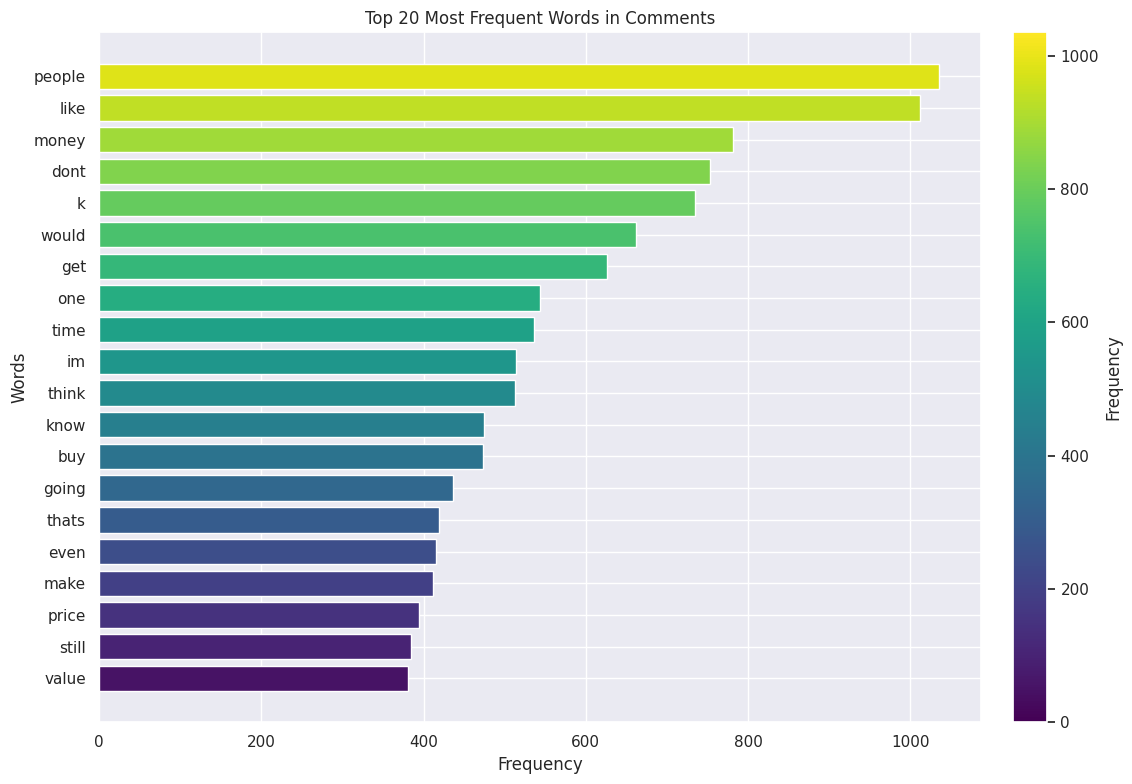

In [ ]:
all_processed_text_combined = ' '.join(df_nlp['processed_text'])

# Tokenize the combined text
words = all_processed_text_combined.split()

# Count the frequency of each word
word_freq = Counter(words)

# Get the most common words and their frequencies
top_words = word_freq.most_common(20)  # Adjust the number as needed

# Extract words and frequencies for plotting
words, frequencies = zip(*reversed(top_words))

colors = sns.color_palette("viridis", len(words))

plt.figure(figsize=(12, 8))
bars = plt.barh(words, frequencies, color=colors)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Most Frequent Words in Comments')

sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=max(frequencies)))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical', pad=0.03)
cbar.set_label('Frequency')

plt.tight_layout()
plt.show()

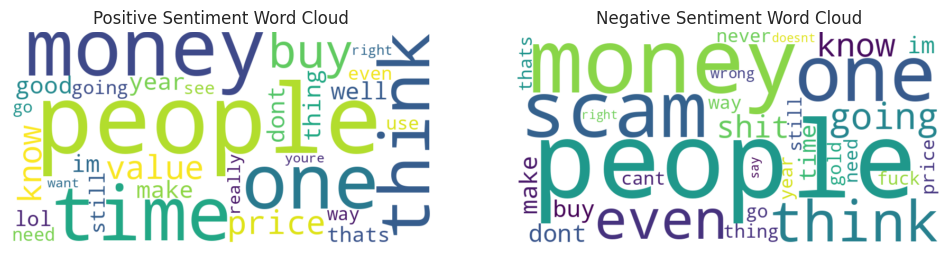

In [ ]:
wordcloud_params = {
    'width': 800,
    'height': 400,
    'background_color': 'white',
    'max_words': 30,
}

positive_text = ' '.join(df_nlp[df_nlp['sentiment_label'] == 'positive']['processed_text'])
positive_wordcloud = WordCloud(**wordcloud_params).generate(positive_text)

negative_text = ' '.join(df_nlp[df_nlp['sentiment_label'] == 'negative']['processed_text'])
negative_wordcloud = WordCloud(**wordcloud_params).generate(negative_text)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')

plt.show()

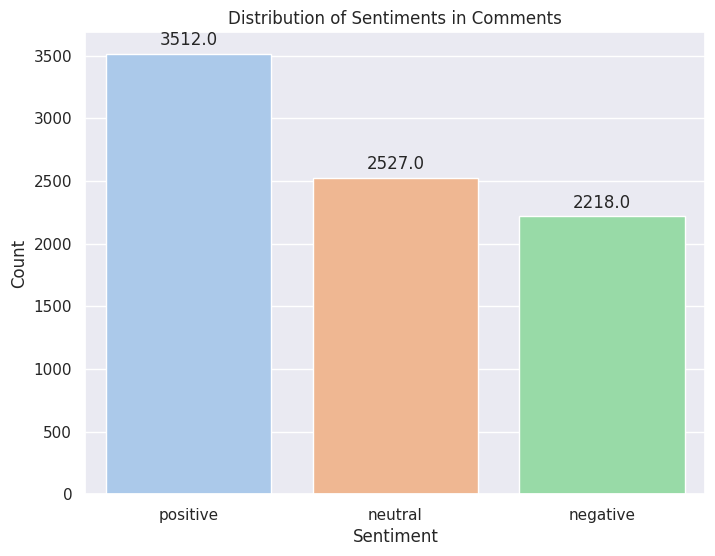

In [ ]:
# Sentiment counts
sentiment_counts = df_nlp['sentiment_label'].value_counts()

colors = sns.color_palette('pastel')

# Create the plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='sentiment_label', data=df_nlp, order=sentiment_counts.index, palette=colors)

ax.set(xlabel='Sentiment', ylabel='Count', title='Distribution of Sentiments in Comments')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

sns.set(style="whitegrid")

plt.show()


# Cryptocurrency Historical Data Retrieval

### Usage
1. Utilize the `get_crypto_data` function to fetch historical data for Bitcoin from CoinMarketCap.
2. The function employs a web scraper (`webdriver.Chrome`) to navigate to the specified URL and extract historical data.
3. The data is then transformed and stored in a Pandas DataFrame.
4. The DataFrame includes columns such as 'Date', 'Open', 'High', 'Low', 'Close', and 'Stock' (set as 'BTC').


In [ ]:
def get_crypto_data():
    driver = webdriver.Chrome(options=chrome_options)
    url = 'https://coinmarketcap.com/currencies/bitcoin/historical-data/'

    driver.get(url)

    try:
        element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'cmc-table'))
        )

        # Click the "Load More" button using JavaScript
        while True:
            try:
                driver.execute_script("arguments[0].click();", WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.CSS_SELECTOR, '.sc-2861d03b-0.iqkKeD'))
                ))
                time.sleep(2)
            except:
                break

        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        table = soup.find('table', {'class': 'cmc-table'})
        data = []

        rows = table.find('tbody').find_all('tr')
        for row in rows:
            cols = row.find_all('td')
            date = cols[0].text.strip()
            open_price = cols[1].text.strip().replace('$', '').replace(',', '')
            high = cols[2].text.strip().replace('$', '').replace(',', '')
            low = cols[3].text.strip().replace('$', '').replace(',', '')
            close = cols[4].text.strip().replace('$', '').replace(',', '')

            # Transform Data
            date = datetime.strptime(date, "%b %d, %Y")
            date = date.strftime("%Y-%m-%d")

            data.append({'Date': date, 'Open': float(open_price), 'High': float(high), 'Low': float(low), 'Close': float(close), 'Stock': 'BTC'})

        df = pd.DataFrame(data)
        df = df.sort_values(by='Date').reset_index(drop=True)

    finally:
        driver.quit()

    return df

In [ ]:
btc_stock = get_crypto_data()
print(btc_stock.shape)

(4901, 6)


In [ ]:
btc_stock = btc_stock.query('Date>="2015-01-01" ')
btc_stock = btc_stock.reset_index(drop=True)

In [ ]:
df = df_nlp

df.date = df.date.apply(parser.parse)
print(df['date'].min().strftime('%Y-%m-%d'), '  ', df['date'].max().strftime('%Y-%m-%d'))

2023-11-12    2023-12-13


In [ ]:
btc_stock_new = btc_stock.tail(6)

min = btc_stock_new['Date'].min()

df['date'] = df['date'].dt.strftime('%Y-%m-%d')

In [ ]:
df = df.query(f'date>="{min}" ')

In [ ]:
df['sentiment_degree'] = df['sentiment_scores'].apply(lambda x: x['compound'])

<ipython-input-129-72a45f6fafcd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_degree'] = df['sentiment_scores'].apply(lambda x: x['compound'])


In [ ]:
btc_stock_grouped = btc_stock_new.groupby(['Date'])['Close'].mean()
btc_comments_grouped = df.groupby(['date'])['sentiment_degree'].mean()

In [ ]:
x1 = btc_stock_grouped.index
y1 = btc_stock_grouped.values

x2 = btc_comments_grouped.index
y2 = btc_comments_grouped.values

min_y1 = btc_stock_grouped.min()
max_y1 = btc_stock_grouped.max()

min_y2 = btc_comments_grouped.min()
max_y2 = btc_comments_grouped.max()

y1_ = (y1 - min_y1)/(max_y1 - min_y1)
y2_ = (y2 - min_y2)/(max_y2 - min_y2)

# Sentiment Over Time Visualization

How the sentiment degree (or polarity) changes over time. It represents the trend of sentiment changes concerning the dates present in the dataset.

By observing the chart:

* If the line is predominantly above the baseline, it indicates a positive sentiment.
* If the line is predominantly below the baseline, it indicates a negative sentiment.
* Fluctuations around the baseline may indicate neutral variations or oscillating sentiments.

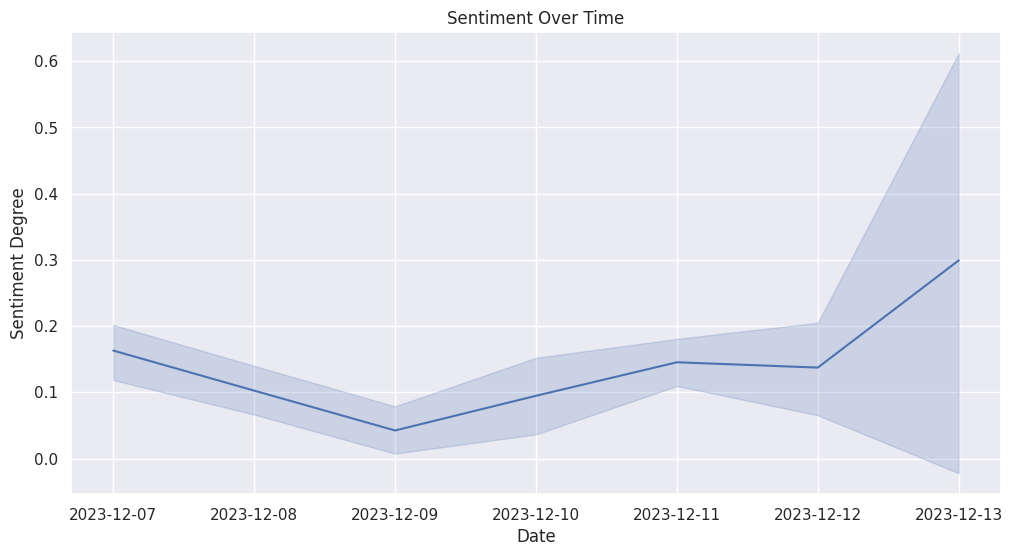

In [ ]:
new_plot = df.sort_values(by='date')
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='sentiment_degree', data=new_plot)
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Degree')
plt.show()

# Time Series Analysis

By observing the plot, one can analyze the relationship or trends between scaled sentiment and stock prices over time. The dashed green line represents sentiment, and the solid blue line represents stock prices. Changes or patterns in the lines may suggest potential correlations or influences between sentiment and stock price movements.

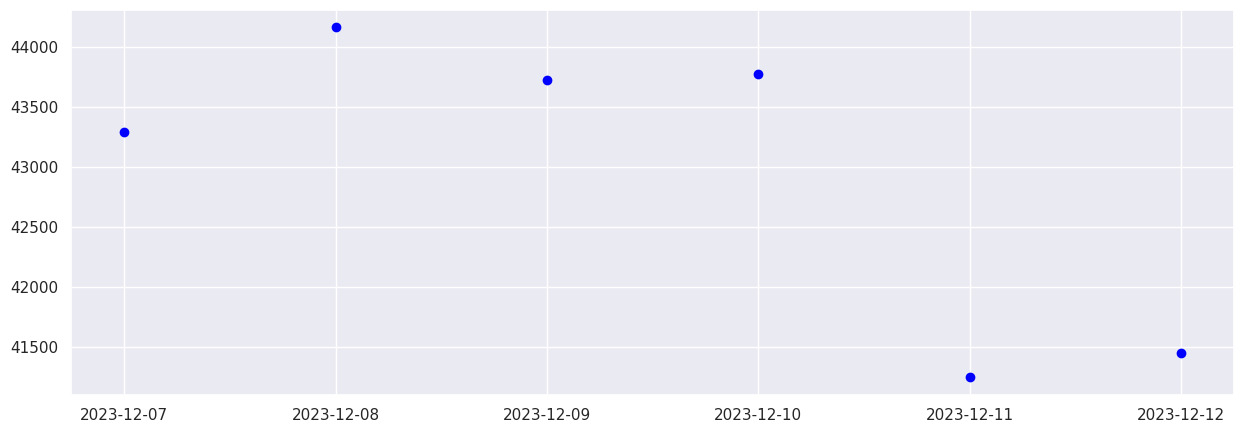

In [ ]:
plt.figure(figsize = (15,5))
plt.scatter(x1, y1,c = 'blue')

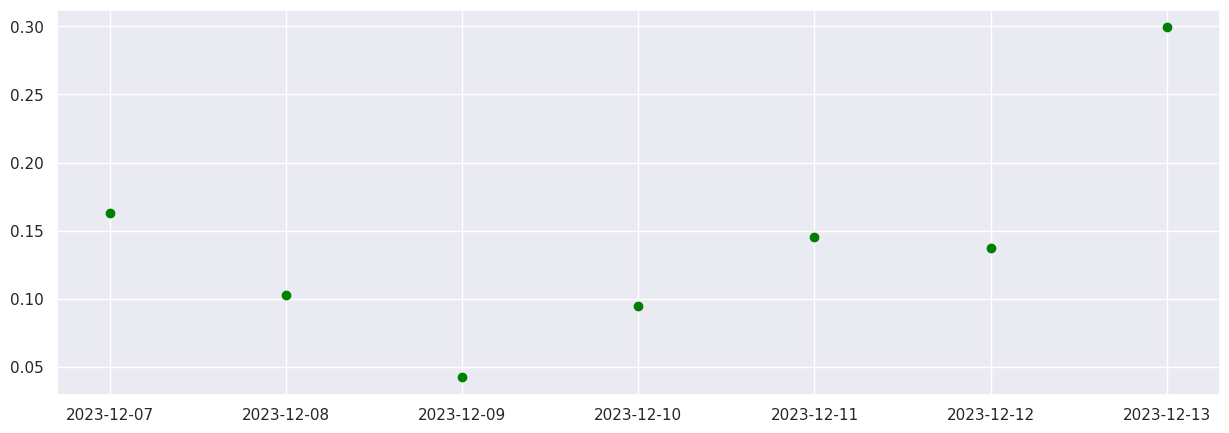

In [ ]:
plt.figure(figsize = (15, 5))
plt.scatter(x2, y2, c = 'green')

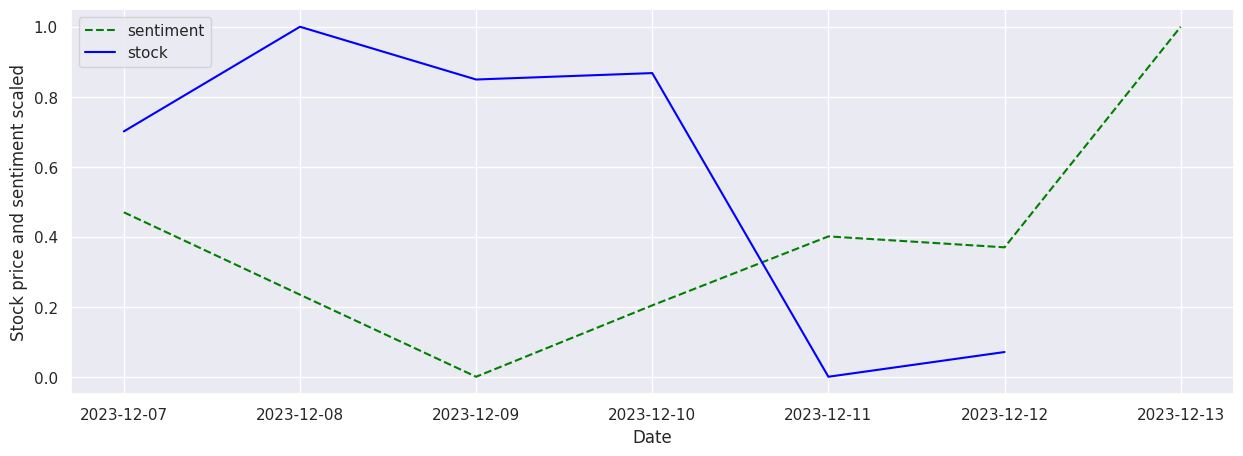

In [ ]:
plt.figure(figsize = (15, 5))
plt.xlabel('Date')
plt.ylabel('Stock price and sentiment scaled')
plt.plot(x2, y2_, label = 'sentiment', c = 'green', linestyle = 'dashed')
plt.plot(x1, y1_, label = 'stock', c = 'blue')
plt.legend()


#LSTM Time Series Forecasting
### This code implements time series forecasting using an LSTM neural network with TensorFlow. Key steps include data preprocessing, defining the neural network model, and training for accurate predictions. The model is then used to forecast future values.

In [ ]:
tf.disable_v2_behavior()

sns.set()
tf.compat.v1.random.set_random_seed(1234)


minmax = MinMaxScaler().fit(btc_stock.iloc[:, 4:5].astype('float32'))
df_log = minmax.transform(btc_stock.iloc[:, 4:5].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log

,0
0,0.002020
1,0.002032
2,0.001528
3,0.001278
4,0.001430
...,...
3263,0.652758
3264,0.646219
3265,0.647016
3266,0.609386


In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((2705, 8), (3238, 1), (30, 1))

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        # Initialize the model with given parameters
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        # Create a MultiRNNCell with multiple LSTM cells
        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )

        # Define placeholders for input data, target output, and hidden layer state
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))

        drop = tf.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )

        # Define a placeholder for the initial state of the hidden layer
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )

        # Apply dynamic RNN to the input data
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )

        # Generate logits from the last output of the dynamic RNN
        self.logits = tf.layers.dense(self.outputs[-1], output_size)

        # Define the mean squared error cost function
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))

        # Define the Adam optimizer to minimize the cost
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    # Calculate accuracy percentage based on the relative error between real and predicted values
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    # Apply smoothing to a time series signal using an anchor algorithm
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer


In [ ]:
def forecast():
    tf.reset_default_graph()

    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )

    # Start a TensorFlow session and initialize global variables
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

    date_ori = pd.to_datetime(btc_stock.iloc[:, 0]).tolist()

    # Create a progress bar for training loop
    pbar = tqdm(range(epoch), desc='train loop')

    # Training loop
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []

        # Iterate through the training data in batches
        for k in range(0, df_train.shape[0] - 1, timestamp):
            idx = (k + timestamp) if (k + timestamp) < (df_train.shape[0] - 1) else (df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k: idx, :].values, axis=0
            )
            batch_y = df_train.iloc[k + 1: idx + 1, :].values

            # Run the neural network model and optimize
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict={
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )

            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))

        # Update the progress bar with training statistics
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))

    future_day = test_size

    # Initialize the array to store the predicted output
    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    # Generate predictions for each batch in the training data
    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict={
                modelnn.X: np.expand_dims(
                    df_train.iloc[k: k + timestamp], axis=0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1: k + timestamp + 1] = out_logits

    # Handle the remaining data not covered by complete batches
    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict={
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis=0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1: df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))

    init_value = last_state

    # Generate predictions for future days
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict={
                modelnn.X: np.expand_dims(o, axis=0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days=1))

    # Inverse transform the predicted values to the original scale
    output_predict = minmax.inverse_transform(output_predict)

    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]


In [ ]:
results = []

num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

for i in range(6):
    print('simulation %d'%(i + 1))
    results.append(forecast())

<ipython-input-158-4c9a65ebf8f5>:14: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)


simulation 1


<ipython-input-158-4c9a65ebf8f5>:42: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(self.outputs[-1], output_size)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [17:12<00:00,  3.44s/it, acc=-579, cost=71.8]
<ipython-input-158-4c9a65ebf8f5>:14: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)


simulation 2


<ipython-input-158-4c9a65ebf8f5>:42: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(self.outputs[-1], output_size)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [18:07<00:00,  3.62s/it, acc=97.4, cost=0.0019]
<ipython-input-158-4c9a65ebf8f5>:14: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)


simulation 3


<ipython-input-158-4c9a65ebf8f5>:42: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(self.outputs[-1], output_size)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [17:15<00:00,  3.45s/it, acc=93.4, cost=0.0169]
<ipython-input-158-4c9a65ebf8f5>:14: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)


simulation 4


<ipython-input-158-4c9a65ebf8f5>:42: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(self.outputs[-1], output_size)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [16:19<00:00,  3.26s/it, acc=97.4, cost=0.00219]
<ipython-input-158-4c9a65ebf8f5>:14: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)


simulation 5


<ipython-input-158-4c9a65ebf8f5>:42: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(self.outputs[-1], output_size)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop:  66%|██████▋   | 199/300 [11:31<05:58,  3.55s/it, acc=97.5, cost=0.00206]

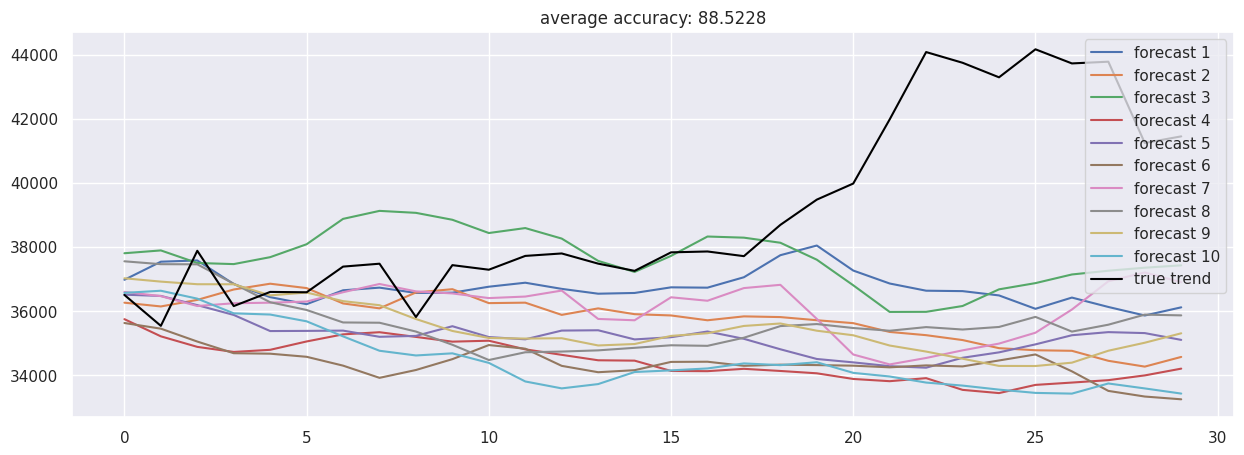

In [ ]:
  accuracies = [calculate_accuracy(btc_stock['Close'].iloc[-test_size:].values, r) for r in results]

  plt.figure(figsize = (15, 5))
  for no, r in enumerate(results):
      plt.plot(r, label = 'forecast %d'%(no + 1))
  plt.plot(btc_stock['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
  plt.legend()
  plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
  plt.show()